# Learn from linear data (plus noise)

Welcome to this notebook. This ntoebook is available at my GitHub http://ww.github.com/pauloabelha/notebooks

I made while delving deep into Machine Learning to understand things from first principles.
All code in here is of my own authorship.
David Mackay's bible was a valuable resource: http://www.inference.org.uk/mackay/itila/book.html
Another amazing book: http://www.gaussianprocess.org/gpml/

In this notebook we compare four different Machine Learning approaches for fitting a function to noisy linear data
- Linear Regression
- Bayesian Linear Regression
- Neural Networks
- Gaussian Processes

Let's get started!

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# for reproducibility
np.random.seed(1)

(1, 10)


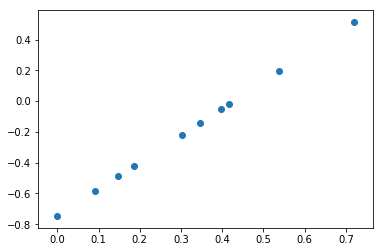

In [44]:
3 for reproducibility
np.random.seed(1)
# noise level (standard deviation of Gaussian distribution for noise)
noise_sigma = 0.05
# generate linear dataset with random Gaussian noise W = WX.T + b + n (n is noise vector)
X = np.random.rand(1,10)
W = np.random.randn(1,1)
b = np.random.randn(1,1)
n = np.random.normal(0,noise_sigma,(1,X.shape[0]))
Y = np.dot(W,X) + b + n
plt.scatter(X, Y)
plt.show()